In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import os
import pandas as pd
import yaml

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns

sns.set_theme()

In [111]:
root_dir = r".\results\2024Apr19-170846_configs" # Adam
root_dir = r".\results\2024Apr19-210045_configs" # Adam + mean
root_dir = r".\results\2024Apr21-002612_configs" # Adam + Dataset Normed

# root_dir = r".\results\2024Apr19-164411_configs"

In [112]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record_combined.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                try:
                    with open(cfg_path, "r") as cfg_file:
                        cfg_data = yaml.safe_load(cfg_file)
                except FileNotFoundError:
                    print(f"Configuration file not found for {file_path}. Skipping...")
                    continue

                # Extract needed parameters, handle missing data gracefully
                run_id = cfg_data.get(
                    "run_id", "unknown"
                )  # Provide default values if key is missing
                tau = cfg_data.get("tau", 0)  # Default value if missing
                min_samples = cfg_data.get("min_samples", 0)  # Default value if missing

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame if not empty, otherwise return an empty DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

# aggregated_df = (
#     combined_data.groupby(["run_id", "tau", "min_samples"])
#     .agg({"epoch": "max"})
#     .reset_index()
# )

# aggregated_df

,epoch,total_loss,scheduler_lr,model,run_id,tau,min_samples
0,0,2275.447466,0,qnet_original,0,0.001,10
1,1,3130.007089,0,qnet_original,0,0.001,10
2,2,2049.786840,0,qnet_original,0,0.001,10
3,3,838.915752,0,qnet_original,0,0.001,10
4,4,89.902022,0,qnet_original,0,0.001,10
...,...,...,...,...,...,...,...
2395,15,0.927298,0,qnet_dataset_normed,9,1.000,10
2396,16,1.058463,0,qnet_dataset_normed,9,1.000,10
2397,17,1.294201,0,qnet_dataset_normed,9,1.000,10
2398,18,0.831518,0,qnet_dataset_normed,9,1.000,10


In [113]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))


def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {
            str(loader.construct_object(key)): loader.construct_object(value)
            for key, value in node.value
        }
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)


yaml.SafeLoader.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
yaml.SafeLoader.add_multi_constructor("", generic_constructor)


def collect_bellman_errors(root_dir):
    all_errors = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith("bellman_error_combined.csv"):
                file_path = os.path.join(subdir, file)
                df_errors = pd.read_csv(file_path)

                cfg_path = os.path.join(subdir, "post_cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                for param, value in cfg_data.items():
                    if isinstance(value, dict):
                        for sub_param, sub_value in value.items():
                            df_errors[f"{param}_{sub_param}"] = sub_value
                    elif isinstance(value, tuple):
                        df_errors[param] = str(value)  # or another formatting that makes sense
                    else:
                        df_errors[param] = value

                all_errors.append(df_errors)

    if all_errors:
        return pd.concat(all_errors)
    else:
        raise ValueError("No CSV files found in the specified directory.")


# Example usage (assuming `root_dir` is defined)
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df = bellman_errors_df.reset_index(drop=True)

bellman_errors_df

,model,bellman_error,alpha,batch_size,cfg_id,cols,epsilon,experiment,experiment_arguments_min_samples,experiment_arguments_tau,...,out_dir,p_success,rows,run_id,seed,start_state,tau,"terminal_states_(8, 8)",title,train_max_iterations
0,qnet_original,0.000659,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,.\results\2024Apr21-002612_configs\0000_tau_0....,1,10,0,2767614137,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20
1,qnet_adjusted_loss,0.108599,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,.\results\2024Apr21-002612_configs\0000_tau_0....,1,10,0,2767614137,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20
2,qnet_dataset_normed,0.110486,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,.\results\2024Apr21-002612_configs\0000_tau_0....,1,10,0,2767614137,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20
3,qnet_original,0.011242,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,.\results\2024Apr21-002612_configs\0000_tau_0....,1,10,1,2715368007,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20
4,qnet_adjusted_loss,0.014909,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,.\results\2024Apr21-002612_configs\0000_tau_0....,1,10,1,2715368007,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,qnet_adjusted_loss,0.001100,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,.\results\2024Apr21-002612_configs\0003_tau_1....,1,10,8,1979902061,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20
116,qnet_dataset_normed,0.186864,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,.\results\2024Apr21-002612_configs\0003_tau_1....,1,10,8,1979902061,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20
117,qnet_original,0.000887,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,.\results\2024Apr21-002612_configs\0003_tau_1....,1,10,9,160771978,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20
118,qnet_adjusted_loss,0.004351,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,.\results\2024Apr21-002612_configs\0003_tau_1....,1,10,9,160771978,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20


In [114]:
bellman_errors_df[bellman_errors_df["bellman_error"].isna()]

,model,bellman_error,alpha,batch_size,cfg_id,cols,epsilon,experiment,experiment_arguments_min_samples,experiment_arguments_tau,...,out_dir,p_success,rows,run_id,seed,start_state,tau,"terminal_states_(8, 8)",title,train_max_iterations


In [115]:
bellman_errors_df[bellman_errors_df["bellman_error"].isna()].shape

(0, 25)

In [116]:
# bellman_errors_df[bellman_errors_df["bellman_error"]>=1]

In [117]:
# bellman_errors_df = bellman_errors_df[bellman_errors_df["bellman_error"] < 1]
bellman_errors_df["bellman_error"] = bellman_errors_df["bellman_error"].fillna(10**32)

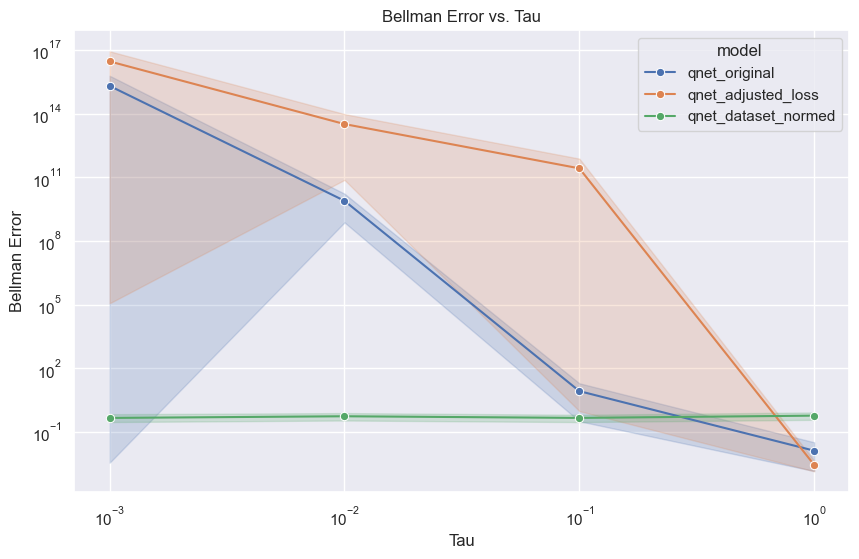

In [118]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=bellman_errors_df,
    x="tau",
    y="bellman_error",
    hue="model",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)


# Adjustments to plot aesthetics
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")

plt.show()

In [119]:
bellman_errors_df.iloc[0]

model                                                                   qnet_original
bellman_error                                                                0.000659
alpha                                                                             0.1
batch_size                                                                         32
cfg_id                                                                              0
cols                                                                               10
epsilon                                                                          0.01
experiment                                                   experiment_distributions
experiment_arguments_min_samples                                                   10
experiment_arguments_tau                                                        0.001
full_title                          2024Apr21-002612_configs_tau=0.001; min_sample...
gamma                                                 

In [120]:
# With access to seeds, check why some examles have much lower bellman errors:

from experiment_src import (
    train_net_with_neural_fitting,
    generate_random_policy_transitions,
    generate_transitions_observations,
    generate_train_test_split_with_valid_path,
    make_env,
)
from experiments.experiment_utils import setup_logger, seed_everything

seed = 3
start_state = (0, 0)
terminal_states = {(8, 8): 1}
rows = 10
cols = 10
p_success = 1.0
num_steps = 40_000
tau = 10
min_samples = 10


def experiment_sample(
    seed,
    start_state,
    terminal_states,
    rows,
    cols,
    p_success,
    num_steps,
    tau,
    min_samples,
):
    seed_everything(seed)

    env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

    states = list(set([s for s, _ in env.mdp.keys()]))
    actions = list(set([a for _, a in env.mdp.keys()]))

    transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

    transitions_train, transitions_val = generate_train_test_split_with_valid_path(
        transitions_list=transitions_list,
        start_state=start_state,
        terminal_states=terminal_states,
        seed=seed,
    )

    train_dataset_transitions = generate_transitions_observations(
        transitions_train, num_steps, tau, min_samples=min_samples
    )

    return train_dataset_transitions


samples = experiment_sample(
    seed,
    start_state,
    terminal_states,
    rows,
    cols,
    p_success,
    num_steps,
    tau,
    min_samples,
)

In [121]:
def sum_rewards(transitions):
    return sum(transition[3] for transition in transitions)


def count_transitions_terminal(transitions, target_value=1.0):
    transition_counts = {}
    for transition in transitions:
        if transition[3] == target_value:
            key = tuple(transition[:3])
            transition_counts[key] = transition_counts.get(key, 0) + 1
    return transition_counts


def count_transitions(transitions):
    transition_counts = {}
    for transition in transitions:
        key = tuple(transition[:3])
        transition_counts[key] = transition_counts.get(key, 0) + 1
    return transition_counts


samples = experiment_sample(
    seed,
    start_state,
    terminal_states,
    rows,
    cols,
    p_success,
    num_steps,
    tau,
    min_samples,
)

sum_rewards(samples)
t_counts = count_transitions(samples)
# len(t_counts)
# t_counts

In [122]:
def process_row(row):
    try:
        terminal_states = {(8, 8): 1.0}
        start_state = (1, 1)
        train_dataset_transitions = experiment_sample(
            seed=row["seed"],
            start_state=start_state,
            terminal_states=terminal_states,
            rows=row["rows"],
            cols=row["cols"],
            p_success=row["p_success"],
            num_steps=row["num_steps"],
            tau=row["tau"],
            min_samples=row["min_samples"],
        )

        sum_of_rewards = sum_rewards(train_dataset_transitions)
        terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
        transition_counts = count_transitions(train_dataset_transitions)

    except Exception as e:
        print(row.to_dict())
        raise e
        
    # Assuming the count_transitions function returns a count you want directly; if it's more complex, adjust accordingly.
    return pd.Series(
        [sum_of_rewards, len(terminal_t_counts), len(transition_counts)],
        index=["sum_rewards", "distinct_terminal_states", "distinct_transitions"],
    )


results_df = bellman_errors_df.apply(process_row, axis=1)

# Concatenate the new results with the original DataFrame
df_with_results = pd.concat([bellman_errors_df, results_df], axis=1)
df_with_results

,model,bellman_error,alpha,batch_size,cfg_id,cols,epsilon,experiment,experiment_arguments_min_samples,experiment_arguments_tau,...,run_id,seed,start_state,tau,"terminal_states_(8, 8)",title,train_max_iterations,sum_rewards,distinct_terminal_states,distinct_transitions
0,qnet_original,0.000659,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,0,2767614137,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20,30.0,3.0,316.0
1,qnet_adjusted_loss,0.108599,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,0,2767614137,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20,30.0,3.0,316.0
2,qnet_dataset_normed,0.110486,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,0,2767614137,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20,30.0,3.0,316.0
3,qnet_original,0.011242,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,1,2715368007,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20,30.0,3.0,316.0
4,qnet_adjusted_loss,0.014909,0.1,32,0,10,0.01,experiment_distributions,10,0.001,...,1,2715368007,"(1, 1)",0.001,1.0,tau=0.001; min_samples=10,20,30.0,3.0,316.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,qnet_adjusted_loss,0.001100,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,8,1979902061,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20,368.0,3.0,316.0
116,qnet_dataset_normed,0.186864,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,8,1979902061,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20,368.0,3.0,316.0
117,qnet_original,0.000887,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,9,160771978,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20,448.0,3.0,316.0
118,qnet_adjusted_loss,0.004351,0.1,32,3,10,0.01,experiment_distributions,10,1.000,...,9,160771978,"(1, 1)",1.000,1.0,tau=1.0; min_samples=10,20,448.0,3.0,316.0


In [123]:
# fail_dict = {'model': 'qnet_original', 
#              'bellman_error': 0.3328666090965271, 
#              'alpha': 0.1, 
#              'batch_size': 32, 
#              'cfg_id': 1, 
#              'cols': 10, 
#              'epsilon': 0.01,
#              'experiment': 'experiment_distributions', 
#              'experiment_arguments_min_samples': 10, 
#              'experiment_arguments_tau': 0.01, 
#              'full_title': '2024Apr15-163128_configs_tau=0.01; min_samples=10', 
#              'gamma': 0.9, 
#              'min_samples': 10, 
#              'num_steps': 40000, 
#              'out_dir': '.\\results\\2024Apr15-163128_configs\\0001_tau_0.01__min_samples_10\\12', 
#              'p_success': 1, 
#              'rows': 10, 
#              'run_id': 12, 
#              'seed': 3211944324, 
#              'start_state': 1, 
#              'tau': 0.01, 
#              'terminal_states_(8, 8)': 1.0, 
#              'title': 'tau=0.01; min_samples=10', 
#              'train_max_iterations': 30}

# seed = fail_dict["seed"]
# rows = fail_dict["rows"]
# cols = fail_dict["cols"]
# p_success = fail_dict["p_success"]
# num_steps = fail_dict["num_steps"]
# tau = fail_dict["tau"]
# min_samples = fail_dict["min_samples"]
# terminal_states = {(8, 8): 1.0}
# start_state = (1, 1)

# seed_everything(seed)

# env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

# states = list(set([s for s, _ in env.mdp.keys()]))
# actions = list(set([a for _, a in env.mdp.keys()]))

# transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

# transitions_train, transitions_val = generate_train_test_split_with_valid_path(
#     transitions_list=transitions_list,
#     start_state=start_state,
#     terminal_states=terminal_states,
#     seed=seed,
# )

# # train_dataset_transitions = generate_transitions_observations(
# #     transitions_train, num_steps, tau, min_samples=min_samples
# # )


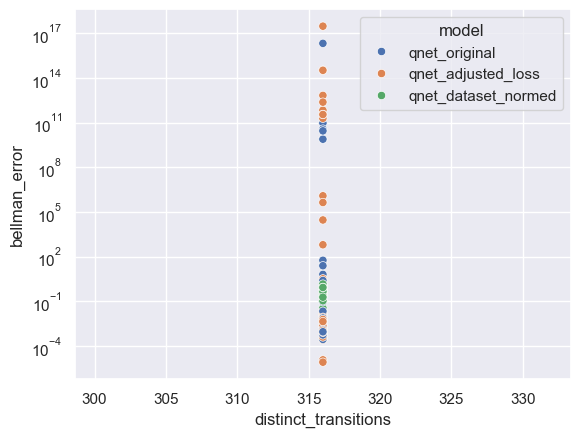

In [124]:
sns.scatterplot(
    data=df_with_results, x="distinct_transitions", y="bellman_error", hue="model"
)
# plt.xscale("log")
plt.yscale("log")
plt.show()

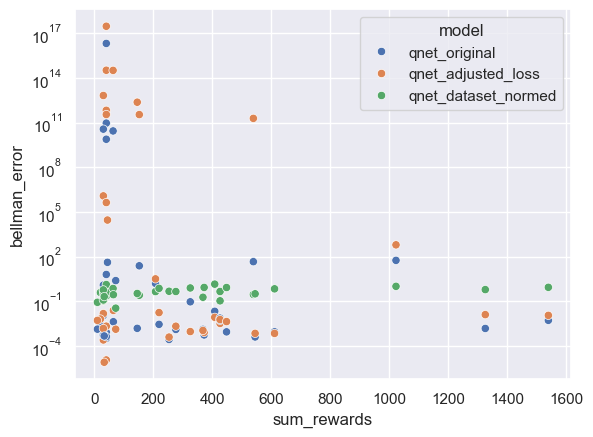

In [125]:
sns.scatterplot(data=df_with_results, x="sum_rewards", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

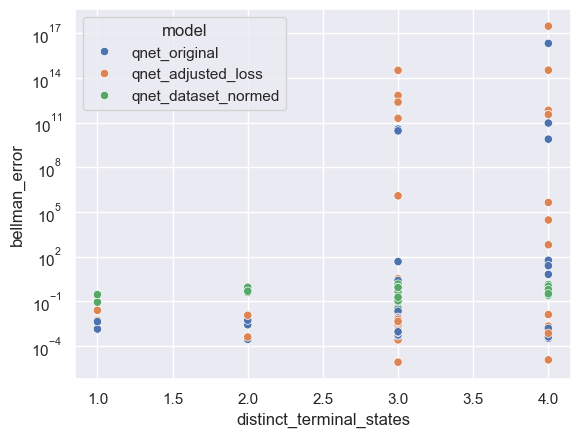

In [126]:
sns.scatterplot(
    data=df_with_results, x="distinct_terminal_states", y="bellman_error", hue="model"
)
# plt.xscale("log")
plt.yscale("log")
plt.show()

In [127]:
# TODO: renormalize dataset frequencies instead of adjusting loss function

### Plot distributions of transitions

In [128]:
def plot_state_counts_heatmap(transitions, title="State Counts"):
    # Convert dataset to DataFrame
    columns = ["state", "action", "next_state", "reward", "done", "prob"]
    df = pd.DataFrame(transitions, columns=columns)

    # Split state and next_state into separate columns for rows and cols
    df[["state_row", "state_col"]] = pd.DataFrame(df["state"].tolist(), index=df.index)
    df[["next_state_row", "next_state_col"]] = pd.DataFrame(
        df["next_state"].tolist(), index=df.index
    )

    # Group by state positions to count occurrences
    train_state_counts = (
        df.groupby(["state_row", "state_col"]).size().reset_index(name="counts")
    )

    # Pivot the counts data for heatmap plotting
    train_state_heatmap = train_state_counts.pivot(
        index="state_row", columns="state_col", values="counts"
    )

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.xlabel("State Column")
    plt.ylabel("State Row")
    plt.show()

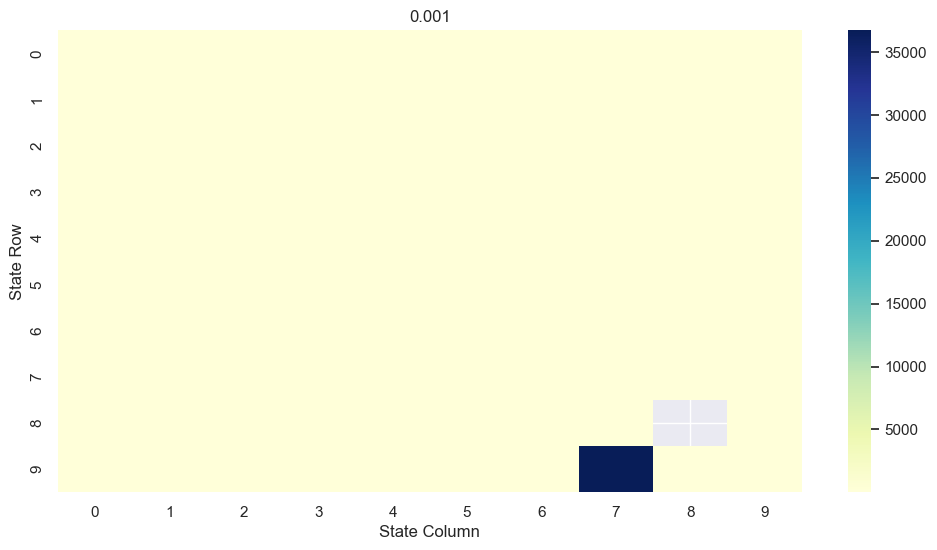

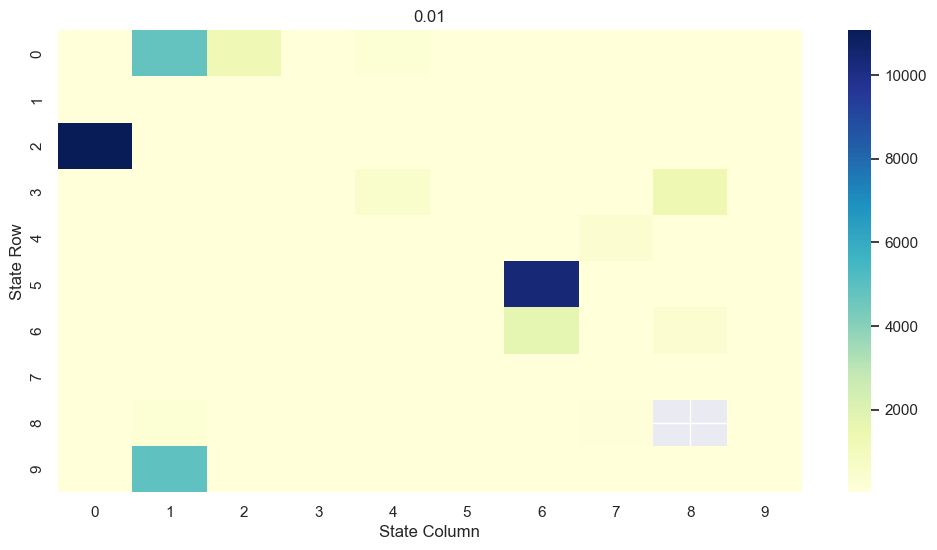

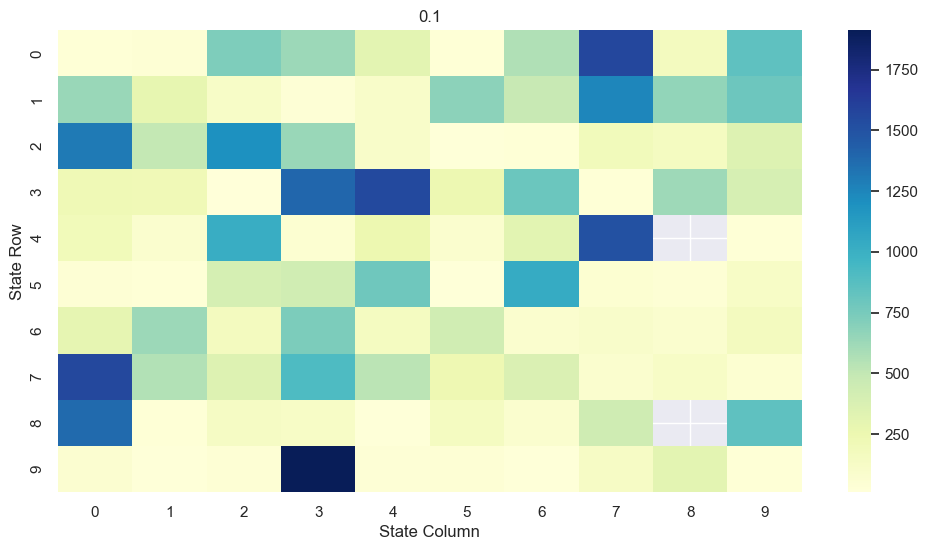

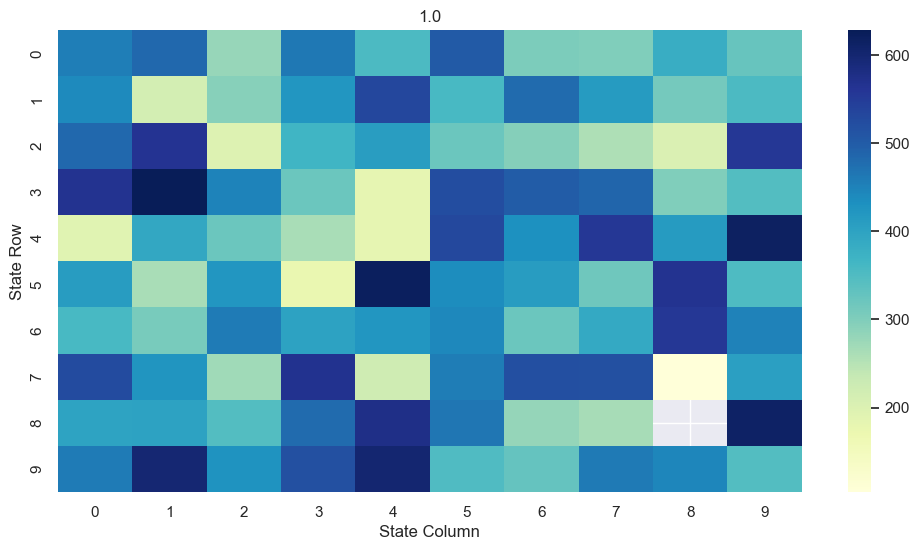

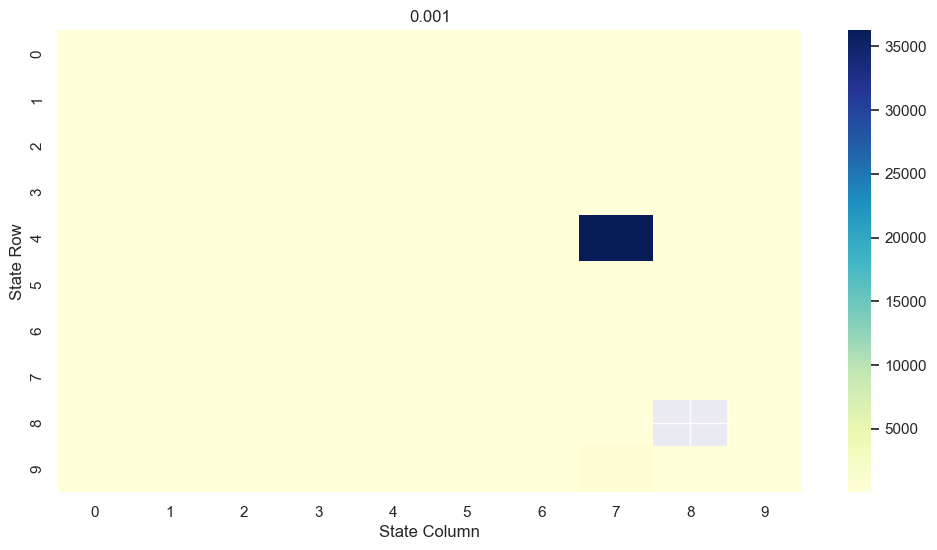

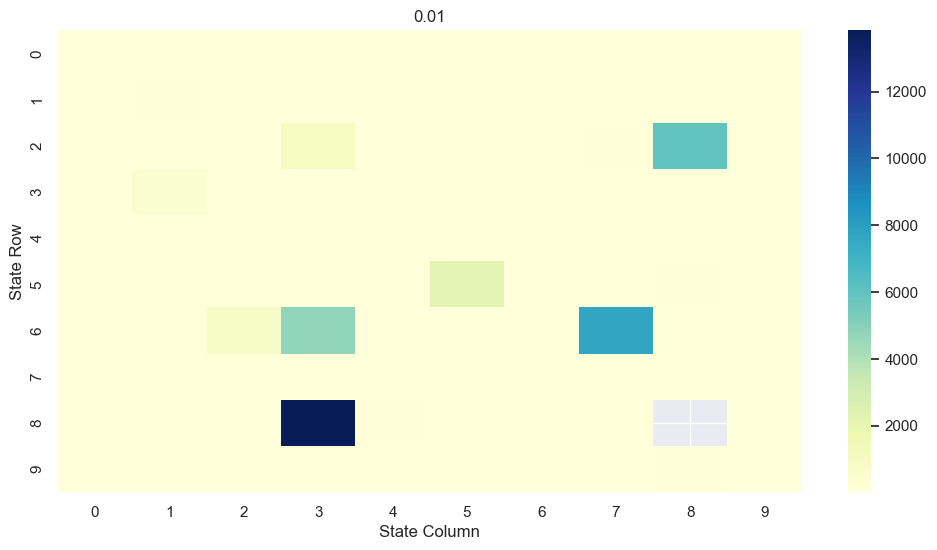

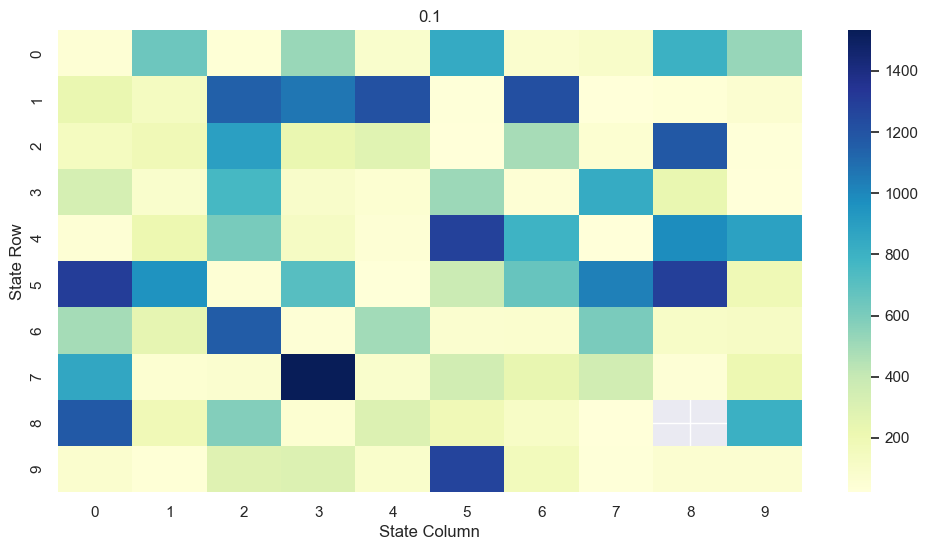

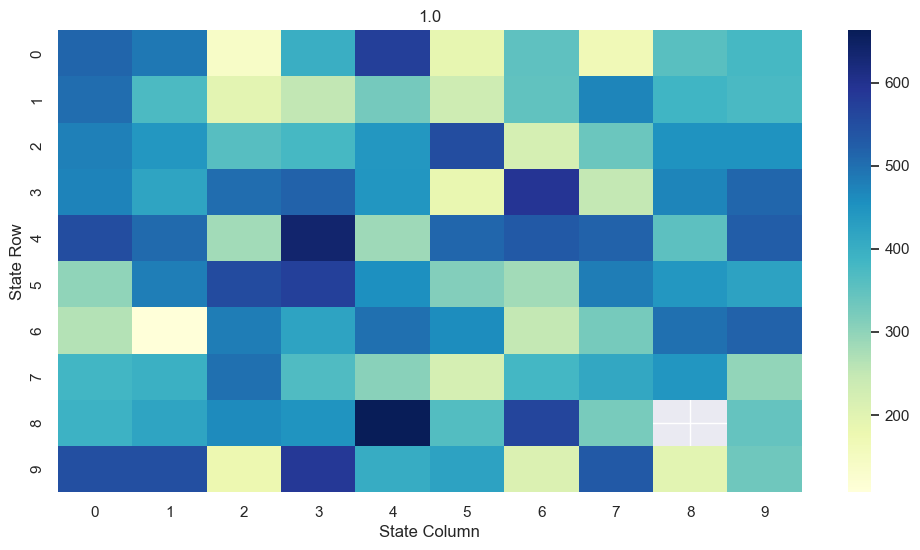

In [129]:
idx_min = bellman_errors_df.groupby('tau')['bellman_error'].idxmin()
idx_max = bellman_errors_df.groupby('tau')['bellman_error'].idxmax()

# Use the indices to select the rows
min_bellman_errors_df = bellman_errors_df.loc[idx_min]
max_bellman_errors_df = bellman_errors_df.loc[idx_max]

# Combine the min and max rows into a single DataFrame
# To ensure no duplicates if min and max are the same row, use pd.concat with drop_duplicates
result_df = pd.concat([min_bellman_errors_df, max_bellman_errors_df]).drop_duplicates()

### Histogram of transitions
for index, row in result_df.iterrows():
    terminal_states = {(8, 8): 1.0}
    start_state = (1, 1)

    # Call experiment_sample with the current row's data
    train_dataset_transitions = experiment_sample(
        seed=row['seed'],
        start_state=start_state,
        terminal_states=terminal_states,
        rows=row['rows'],
        cols=row['cols'],
        p_success=row['p_success'],
        num_steps=row['num_steps'],
        tau=row['tau'],
        min_samples=row['min_samples'],
    )

    plot_state_counts_heatmap(train_dataset_transitions, title=f"{row['tau']}")

    # # Compute the desired metrics
    # sum_of_rewards = sum_rewards(train_dataset_transitions)
    # terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
    # transition_counts = count_transitions(train_dataset_transitions)


    # data = {
    #     "Transitions": [f"{key[0]} {key[1]} {key[2]}" for key in transition_counts.keys()],
    #     "Counts": list(transition_counts.values())
    # }

    # df = pd.DataFrame(data)
    # plt.figure(figsize=(10, 6))
    # sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")

    # # Adding titles and labels
    # plt.title(f'{row["model"]}, {row["tau"]}, {row["min_samples"]}, {row["bellman_error"]}')
    # plt.xlabel('Transitions')
    # plt.ylabel('Counts')
    # # plt.xticks(rotation=90, ha="right")
    # plt.xticks([])

    # # Display the plot
    # plt.tight_layout()
    # plt.show()

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_21124\2157596148.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
C:\Users\Chainsword\AppData\Local\Temp\ipykernel_21124\2157596148.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


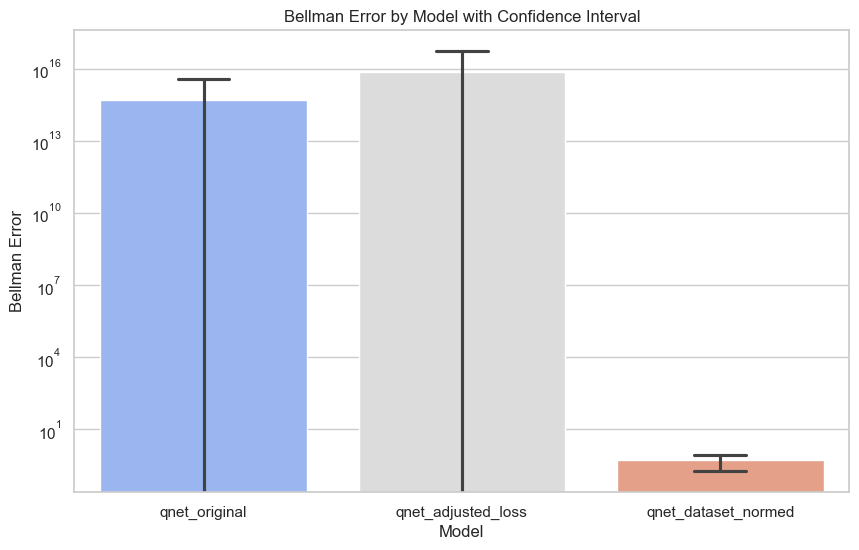

In [130]:
# Assuming your DataFrame is named df
sns.set_theme(style="whitegrid")  # Setting the theme for the plots

plt.figure(figsize=(10, 6))  # Setting the figure size
ax = sns.barplot(
    x="model",
    y="bellman_error",
    data=bellman_errors_df,
    ci="sd",
    palette="coolwarm",
    capsize=0.2,
)

plt.title("Bellman Error by Model with Confidence Interval")
plt.ylabel("Bellman Error")
plt.xlabel("Model")
plt.yscale(
    "log"
)  # Optional: use logarithmic scale for better visualization of wide value ranges

plt.show()